# Figures 5-6

In [6]:
import openai
import pickle
import pandas as pd

In [7]:
import pickle
with open('../disease_class/diseasetissue_dict_emb_stack.pickle', 'rb') as handle:
    disease_dict_emb = pickle.load(handle)

In [8]:
df = pd.DataFrame.from_dict(disease_dict_emb)

In [9]:
corr_llm = df.corr()

In [10]:
import scanpy as sc
adata_train = sc.read_h5ad("/projects/site/gred/resbioai/liut61/adata_train_diseaseembeddings.h5ad")
adata_valid = sc.read_h5ad("/projects/site/gred/resbioai/liut61/adata_valid_diseaseembeddings.h5ad")
adata_test = sc.read_h5ad("/projects/site/gred/resbioai/liut61/adata_test_diseaseembeddings.h5ad")

/home/liut61/miniforge3/envs/cellm/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [11]:
adata = adata_train

In [12]:
adata = adata[adata.obs['tissue'] != '']

In [13]:
from scimilarity.utils import clean_tissues

In [14]:
adata.obs['tissue_clean'] = clean_tissues(adata.obs['tissue'])

/tmp/ipykernel_727961/2732222971.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['tissue_clean'] = clean_tissues(adata.obs['tissue'])


In [15]:
adata.obs['tissue_clean'] = adata.obs['tissue_clean'].astype('category')

In [16]:
for i in adata.obs['tissue_clean'].unique():
    print(i)

female reproduction
nan
blood
gut
brain
liver
lung
heart
kidney
airway
bone marrow
skin
adrenal gland
spleen
lymph node
eye
bladder
breast
thymus
male reproduction
stomach
pancreas


In [18]:
import numpy as np

In [19]:
dict_train_emb = {}
for i in ["Alzheimer's disease", 'B-cell acute lymphoblastic leukemia', 'COVID-19', "Crohn's disease", 'lung adenocarcinoma', 'melanoma', 'multiple myeloma', 'multiple sclerosis']:
    adata_new = adata[adata.obs['true'] == i]
    for j in adata_new.obs['tissue_clean'].unique():
        if str(j) != 'nan':
            adata_new_c = adata_new[adata_new.obs['tissue_clean']== j]
            dict_train_emb[str(i)+'_'+str(j)] = np.mean(adata_new_c.X, axis=0)

In [20]:
df = pd.DataFrame.from_dict(dict_train_emb)

In [21]:
disease_dict_emb_nohealthy = {}

for item in disease_dict_emb.keys():
    if 'healthy' not in item:
        disease_dict_emb_nohealthy[item] = disease_dict_emb[item]

In [22]:
df_gpt = pd.DataFrame.from_dict(disease_dict_emb_nohealthy)

In [23]:
from itertools import combinations

In [24]:
df_gene = df.corr()
df_gpt = df_gpt.corr()

In [62]:
df_gene.shape

(16, 16)

In [64]:
df_gpt = df_gpt.loc[df_gene.columns, df_gene.columns]

In [65]:
import scipy.stats
scipy.stats.pearsonr(df_gene.values.flatten(), df_gpt.values.flatten())

PearsonRResult(statistic=0.6549408404058654, pvalue=9.517433896059191e-33)

<Axes: >

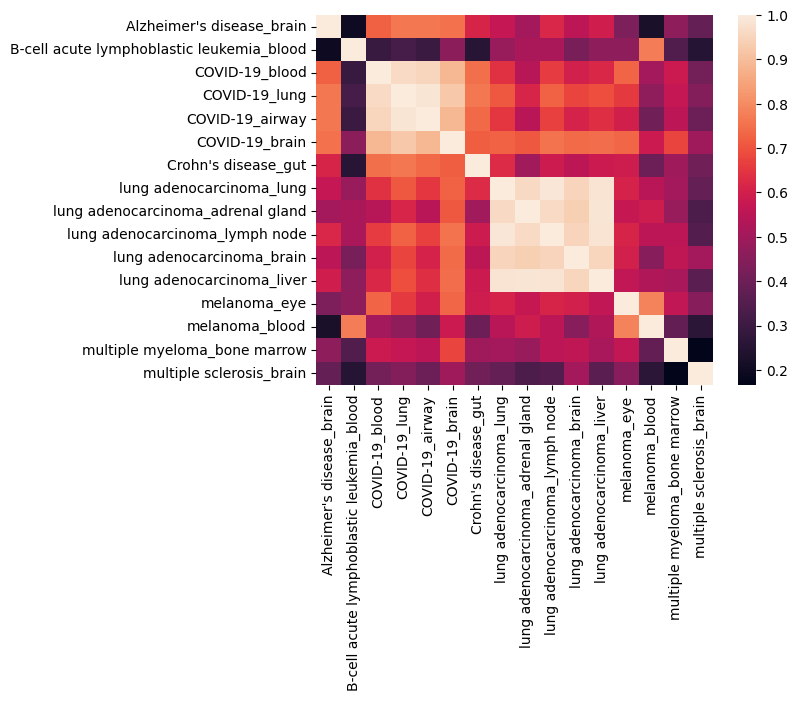

In [69]:
import seaborn as sns
sns.heatmap(df_gene)

<Axes: >

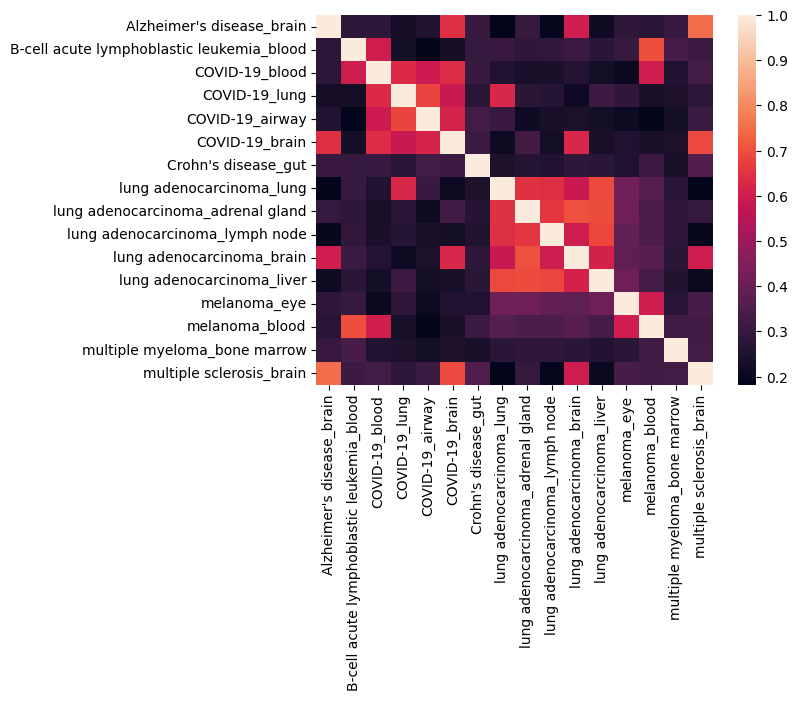

In [70]:
sns.heatmap(df_gpt)

In [79]:
adata = sc.read("/projects/site/gred/resbioai/liut61/adata_train_psbulk_multilabel.h5ad")
adata_withtiss = sc.read_h5ad("/projects/site/gred/resbioai/liut61/adata_train_diseaseembeddings.h5ad")

In [87]:
adata.obs

,disease,disease_label
0,4,healthy
1,4,healthy
2,2,COVID-19
3,4,healthy
4,4,healthy
...,...,...
1936,4,healthy
1937,2,COVID-19
1938,4,healthy
1939,4,healthy


In [89]:
adata_withtiss.obs
adata.obs['tissue_clean'] = clean_tissues(adata_withtiss.obs['tissue']).values

In [90]:
with open("/projects/site/gred/resbioai/liut61/disease_loader_overlap9.pickle", 'rb') as handle:
    disease_label_dict = pickle.load(handle)

In [91]:
disease_label_dict_inv = {}
for i in  disease_label_dict.keys():
    disease_label_dict_inv[disease_label_dict[i]] = i

In [92]:
adata.obs['disease_label'] = [disease_label_dict_inv[i] for i in adata.obs.disease]

In [94]:
dict_pseudo_emb = {}
for i in ["Alzheimer's disease", 'B-cell acute lymphoblastic leukemia', 'COVID-19', "Crohn's disease", 'lung adenocarcinoma', 'melanoma', 'multiple myeloma', 'multiple sclerosis']:
    adata_new = adata[adata.obs['disease_label'] == i]
    for j in adata_new.obs['tissue_clean'].unique():
        if str(j) != 'nan':
            adata_new_c = adata_new[adata_new.obs['tissue_clean']== j]
            dict_pseudo_emb[str(i)+'_'+str(j)] = np.mean(adata_new_c.X, axis=0)

In [95]:
df_pseudo = pd.DataFrame.from_dict(dict_pseudo_emb)

In [97]:
df_pseudobulk = df_pseudo.corr()

In [98]:
import scipy.stats
scipy.stats.pearsonr(df_pseudobulk.values.flatten(), df_gpt.values.flatten())

PearsonRResult(statistic=0.28896250600874523, pvalue=2.5831763608095842e-06)

<Axes: >

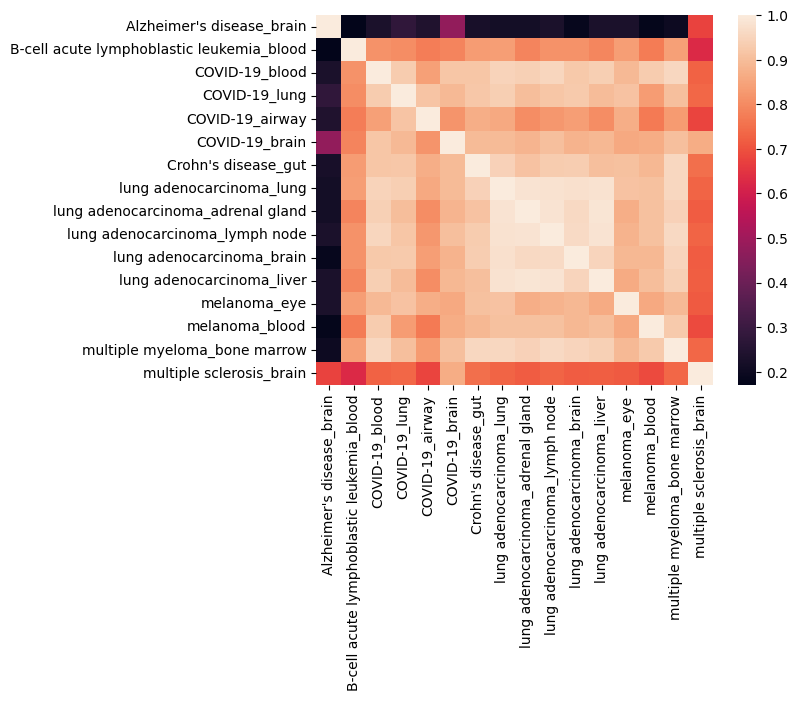

In [99]:
sns.heatmap(df_pseudobulk)

In [25]:
seq1 = []
seq2 = []
for i in list(combinations(df_gene.columns,2)):
    seq1.append(df_gpt.loc[i[0], i[1]])
    seq2.append(df_gene.loc[i[0], i[1]])
    # seq1.append(df_gpt.loc[i[1], i[0]])
    # seq2.append(df_gene.loc[i[1], i[0]])

# for i in list(df_llm.columns):
#     seq1.append(df_gpt.loc[i, i])
#     seq2.append(df_gene.loc[i, i])

In [26]:
import matplotlib.pyplot as plt
import sklearn
from scipy import stats

slope, intercept, r, p, std_err = stats.linregress(seq1, seq2, alternative='greater')

In [27]:
print(slope, intercept, p)

0.6356994901112853 0.37061400333146144 3.6543266754429903e-10


In [28]:
import matplotlib.cm as cm

In [33]:
adata.obs.true.unique()

['healthy', 'COVID-19', 'multiple sclerosis', 'Crohn's disease', 'Alzheimer's disease', 'lung adenocarcinoma', 'melanoma', 'multiple myeloma', 'B-cell acute lymphoblastic leukemia']
Categories (9, object): ['Alzheimer's disease', 'B-cell acute lymphoblastic leukemia', 'COVID-19', 'Crohn's disease', ..., 'lung adenocarcinoma', 'melanoma', 'multiple myeloma', 'multiple sclerosis']

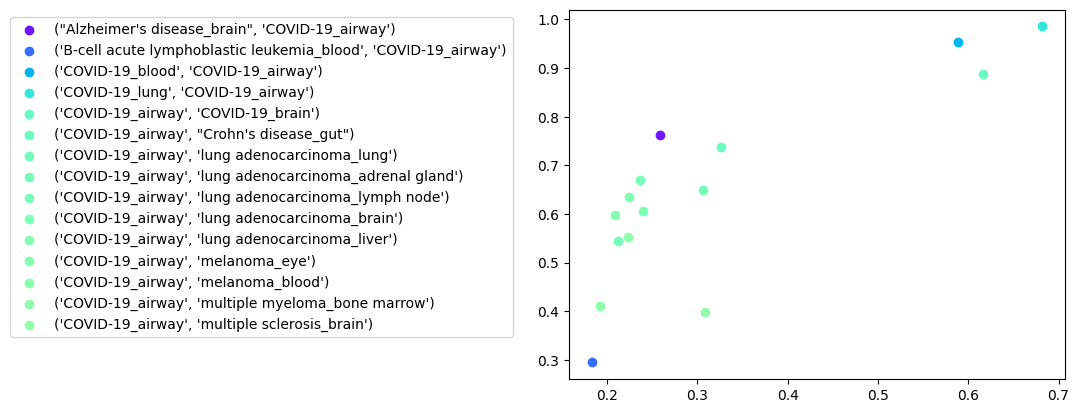

In [49]:
colors = cm.rainbow(np.linspace(0, 1, len(seq1)))
dis = "_airway"
for i,j,k in zip(range(len(seq1)), list(combinations(df_gene.columns,2)), colors):
    if (dis in j[0]) or (dis in j[1]):
        plt.scatter(seq1[i],seq2[i], label = j, color=k)

# plt.plot(seq1, slope*np.array(seq1)+intercept, c='black')
plt.legend(bbox_to_anchor=(-0.1,1))

PearsonRResult(statistic=0.8318350865923925, pvalue=0.00012035940378935287)


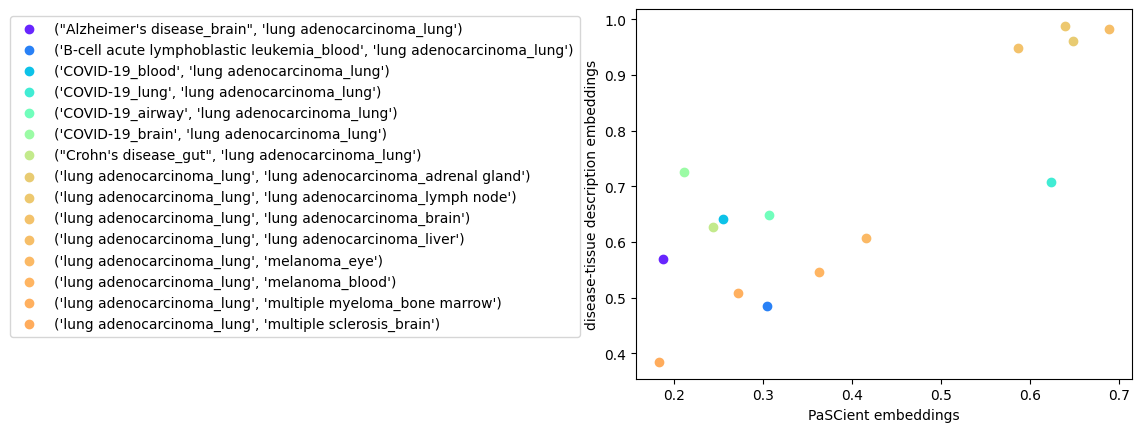

In [107]:
colors = cm.rainbow(np.linspace(0, 1, len(seq1)))
dis = "lung adenocarcinoma_lung"
corl1 = []
corl2 = []
for i,j,k in zip(range(len(seq1)), list(combinations(df_gene.columns,2)), colors):
    if (dis in j[0]) or (dis in j[1]):
        plt.scatter(seq1[i],seq2[i], label = j, color=k)
        corl1.append(seq1[i])
        corl2.append(seq2[i])

# plt.plot(seq1, slope*np.array(seq1)+intercept, c='black')
plt.xlabel('PaSCient embeddings')
plt.ylabel('disease-tissue description embeddings')
plt.legend(bbox_to_anchor=(-0.1,1))

print(scipy.stats.pearsonr(corl1, corl2))

PearsonRResult(statistic=0.721465506120502, pvalue=0.002397038243545052)


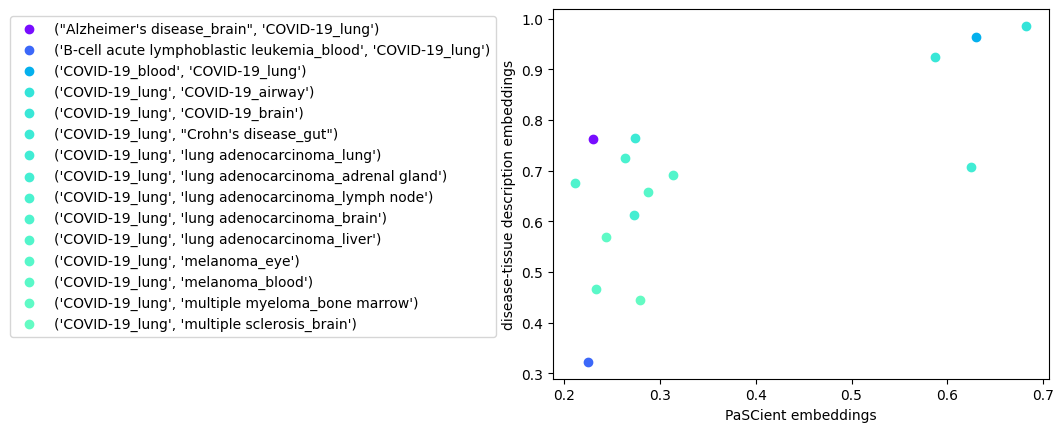

In [108]:
colors = cm.rainbow(np.linspace(0, 1, len(seq1)))
dis = "COVID-19_lung"
corl1 = []
corl2 = []
for i,j,k in zip(range(len(seq1)), list(combinations(df_gene.columns,2)), colors):
    if (dis in j[0]) or (dis in j[1]):
        plt.scatter(seq1[i],seq2[i], label = j, color=k)
        corl1.append(seq1[i])
        corl2.append(seq2[i])
# plt.plot(seq1, slope*np.array(seq1)+intercept, c='black')
plt.xlabel('PaSCient embeddings')
plt.ylabel('disease-tissue description embeddings')
plt.legend(bbox_to_anchor=(-0.1,1))
print(scipy.stats.pearsonr(corl1, corl2))